In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import nltk
import re
import pprint
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk import collocations
from sklearn import preprocessing
import seaborn as sns
import string
from nltk import collocations
from textblob import TextBlob
# wordcloud
from wordcloud import WordCloud, STOPWORDS
# clustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sentic import SenticPhrase
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
import requests, json
from dateutil import tz
from sklearn.cluster import KMeans
plt.rcParams['figure.figsize'] = [16, 6]

# Carga de archivos con data de usuarios troll y no troll

In [2]:
df_ntrolls = pd.read_csv("dataset/dataset_ntroll.csv", sep=",", encoding='utf-8',index_col=0)
df_trolls = pd.read_csv("dataset/dataset_troll.csv", sep=",", encoding='utf-8',index_col=0)
df = pd.concat([df_trolls, df_ntrolls])
df

/media/mdleiton/Respaldo/repositorios/AED/env/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3,4,8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


content followers  \
author                                                                         
Christi98823048  @MashiRafael Asustado te veo ladrón! Irás a la...         0   
Christi98823048  @MashiRafael La década saqueada y robada maldi...         0   
Christi98823048  @Guaytamba_LDU @LDU_Oficial Genial! Hablamos p...         0   
Christi98823048  @MashiRafael Cárcel para todos los alcahuetes ...         0   
Christi98823048  @MashiRafael Ya valió el Liverpool gracias al ...         0   
Christi98823048      @MashiRafael Ahí es donde vas a parar LADRÓN!         0   
Christi98823048  @MashiRafael Traduce tu mismo! Eres una bestia...         0   
Christi98823048  @MashiRafael Y el abuso de justicia y poder qu...         0   
Christi98823048  @MashiRafael Cuando te "sacrificas" tu?? El Ec...         0   
Christi98823048  @MashiRafael Lo que queremos es que tu acabes ...         0   
Christi98823048  @MashiRafael Década robada y manipulada. Fuist...         0   
Christi98823048  @lejandoors @MashiRafael @LuisaMaldonadoM @rel...         0   
Christi98823048  @MashiRafael Querrás decir a seguir robando la...         0   
Christi98823048  @MashiRafael Entonces xq no vienes a Ecuador y...         0   
Christi98823048  @MashiRafael Quieren recuperar la patria? o es...         0   
Christi98823048  @MashiRafael Y todos los milloncitos que Tú! Y...         0   
Christi98823048  @MashiRafael Me suena a que te describes a sí ...         0   
Christi98823048  @MashiRafael Ladrón! También deberías estar en...         0   
Christi98823048  RT @luisevivanco: Leo una avalancha de curuchu...         0   
Christi98823048       @MashiRafael Ladrón! Prófugo de la justicia!         0   
Leonard36262814  @MashiRafael Pero como los van a encontrar; a ...         0   
Leonard36262814  @MashiRafael El que deberia ir preso es usted ...         0   
Leonard36262814  @MashiRafael Cuanto le habra ofrecido para que...         0   
Leonard36262814  @MashiRafael Que sinismo al decir eso o se olv...         0   
Leonard36262814  @MashiRafael Que sinismo! De que dinero invert...         0   
Leonard36262814  @MashiRafael Sinico sinverguenza al decir eso ...         0   
Leonard36262814  @MashiRafael Que sinismo al hablar de quien ti...         0   
Leonard36262814       @MashiRafael Inmoral https://t.co/gDTj5KzneD         0   
Leonard36262814  @MashiRafael El ex vicepresidente y si esta ha...         0   
Leonard36262814                                   @MashiRafael 🐀🐀🐀         0   
...                                                            ...       ...   
DelPatibulo      RT @cristiancrespoj: Más medicina de guerra en...       156   
DelPatibulo      RT @jguaido: Estamos en recorrido revisando la...       156   
DelPatibulo      RT @cristiancrespoj: Medicina de guerra en #Ve...       156   
DelPatibulo      RT @cristiancrespoj: Caos por el transporte en...       156   
DelPatibulo      El caos en Venezuela no hay agua no hay luz no...       156   
DelPatibulo      RT @maryorinmendez: Ante la gravedad del asunt...       156   
DelPatibulo      El exitoso modelo del socialismo del siglo 21 ...       156   
DelPatibulo      RT @ProanoMaya: La mujer es un gran corazón. N...       156   
DelPatibulo      RT @alperezs: Paco "Tababela" Moncayo en Quito...       156   
DelPatibulo      @mbachelet Cállate y mueve tus nalgas y anda v...       156   
DelPatibulo      RT @jguaido: Saboteo es robarse el dinero de l...       156   
DelPatibulo      RT @AllanRowen: Entrenando para ser Correista!...       156   
DelPatibulo      RT @momentoviral: - Un extraño le tocó sin raz...       156   
DelPatibulo      RT @jguaido: 11 PM.   22 estados sin luz.   6 ...       156   
DelPatibulo      RT @jguaido: Tenemos El Guri; Tocoma y Caruach...       156   
DelPatibulo      Los mahuadistas que pactaron con el correismo ...       156   
DelPatibulo      RT @teleamazonasec: Madre de hijos drogadictos...       156   
DelPatibulo      @amandaasubiar @ArboledaJC1983 Imbecil por

In [ ]:
df = df.dropna()

## Preprocesamiento de los tweets
### Se definen el conjunto de stopwords a utilizar y la función que se encargar de extraer: hastag, íconos, urls, signos de puntuación de cada contenido de un tweet.

In [3]:
# definiendo conjunto de palabras a considerar como stopwords(no serán consideradas en el análisis)
stopwords_set = stopwords.words('spanish')
stopwords_set.extend(stopwords.words('english'))
stopwords_set.extend(['aquí', 'así'])
stopwords_set = set(stopwords_set)

def limpieza_tweet(tweets):
    # quitando icons
    tweet = str(tweets["content"]).lower()
    sin_icons = re.sub(r'\$\w*','',tweet)
    # obteniendo palabras
    tw_Tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
    temp_tweet_list = tw_Tokenizer.tokenize(sin_icons)
    # quitando urls/direcciones
    sin_https = [re.sub(r'https?:\/\/.*\/\w*|t.co\/\w*','',i) for i in temp_tweet_list]
    # quitando hashtags
    sin_hashtags = [re.sub(r'#|https', '', i) for i in sin_https]
    # quitando signos de puntuación
    sin_puntuacion = [re.sub(r'[' + string.punctuation + ']+', ' ', i) for i in sin_hashtags]
    sin_puntuacion = [re.sub(r'[“’—‘”–…]+', ' ', i) for i in sin_puntuacion]
    
    new_tweet = ' '.join(sin_puntuacion)
    filtrada_palabras = tw_Tokenizer.tokenize(new_tweet)
    filtrada_palabras = [re.sub(r'^\w\w?$', '', i) for i in filtrada_palabras]
    
    filtrada =' '.join(filtrada_palabras)
    tweet_final = re.sub(r'\s\s+', ' ', filtrada)
    # quitando stopwords
    tweet_final = tweet_final.strip(' ').split(' ')
    sin_stopwords = [i for i in tweet_final if (i.lower() not in stopwords_set and len(i)>1 and not i.isdigit())]
    #obteniendo los emoticones para luego analizar
    emoticones = [i for i in tweet_final if (i.lower() not in stopwords_set and len(i)==1) ]
    tweets["emoticones"] = ' '.join(emoticones)
    tweets["sin_stopwords"] = ' '.join(sin_stopwords)
    return tweets

In [4]:
df = df.apply(limpieza_tweet, axis=1)

In [9]:
df

content followers  \
author                                                                         
Christi98823048  @MashiRafael Asustado te veo ladrón! Irás a la...         0   
Christi98823048  @MashiRafael La década saqueada y robada maldi...         0   
Christi98823048  @Guaytamba_LDU @LDU_Oficial Genial! Hablamos p...         0   
Christi98823048  @MashiRafael Cárcel para todos los alcahuetes ...         0   
Christi98823048  @MashiRafael Ya valió el Liverpool gracias al ...         0   
Christi98823048      @MashiRafael Ahí es donde vas a parar LADRÓN!         0   
Christi98823048  @MashiRafael Traduce tu mismo! Eres una bestia...         0   
Christi98823048  @MashiRafael Y el abuso de justicia y poder qu...         0   
Christi98823048  @MashiRafael Cuando te "sacrificas" tu?? El Ec...         0   
Christi98823048  @MashiRafael Lo que queremos es que tu acabes ...         0   
Christi98823048  @MashiRafael Década robada y manipulada. Fuist...         0   
Christi98823048  @lejandoors @MashiRafael @LuisaMaldonadoM @rel...         0   
Christi98823048  @MashiRafael Querrás decir a seguir robando la...         0   
Christi98823048  @MashiRafael Entonces xq no vienes a Ecuador y...         0   
Christi98823048  @MashiRafael Quieren recuperar la patria? o es...         0   
Christi98823048  @MashiRafael Y todos los milloncitos que Tú! Y...         0   
Christi98823048  @MashiRafael Me suena a que te describes a sí ...         0   
Christi98823048  @MashiRafael Ladrón! También deberías estar en...         0   
Christi98823048  RT @luisevivanco: Leo una avalancha de curuchu...         0   
Christi98823048       @MashiRafael Ladrón! Prófugo de la justicia!         0   
Leonard36262814  @MashiRafael Pero como los van a encontrar; a ...         0   
Leonard36262814  @MashiRafael El que deberia ir preso es usted ...         0   
Leonard36262814  @MashiRafael Cuanto le habra ofrecido para que...         0   
Leonard36262814  @MashiRafael Que sinismo al decir eso o se olv...         0   
Leonard36262814  @MashiRafael Que sinismo! De que dinero invert...         0   
Leonard36262814  @MashiRafael Sinico sinverguenza al decir eso ...         0   
Leonard36262814  @MashiRafael Que sinismo al hablar de quien ti...         0   
Leonard36262814       @MashiRafael Inmoral https://t.co/gDTj5KzneD         0   
Leonard36262814  @MashiRafael El ex vicepresidente y si esta ha...         0   
Leonard36262814                                   @MashiRafael 🐀🐀🐀         0   
...                                                            ...       ...   
DelPatibulo      RT @cristiancrespoj: Más medicina de guerra en...       156   
DelPatibulo      RT @jguaido: Estamos en recorrido revisando la...       156   
DelPatibulo      RT @cristiancrespoj: Medicina de guerra en #Ve...       156   
DelPatibulo      RT @cristiancrespoj: Caos por el transporte en...       156   
DelPatibulo      El caos en Venezuela no hay agua no hay luz no...       156   
DelPatibulo      RT @maryorinmendez: Ante la gravedad del asunt...       156   
DelPatibulo      El exitoso modelo del socialismo del siglo 21 ...       156   
DelPatibulo      RT @ProanoMaya: La mujer es un gran corazón. N...       156   
DelPatibulo      RT @alperezs: Paco "Tababela" Moncayo en Quito...       156   
DelPatibulo      @mbachelet Cállate y mueve tus nalgas y anda v...       156   
DelPatibulo      RT @jguaido: Saboteo es robarse el dinero de l...       156   
DelPatibulo      RT @AllanRowen: Entrenando para ser Correista!...       156   
DelPatibulo      RT @momentoviral: - Un extraño le tocó sin raz...       156   
DelPatibulo      RT @jguaido: 11 PM.   22 estados sin luz.   6 ...       156   
DelPatibulo      RT @jguaido: Tenemos El Guri; Tocoma y Caruach...       156   
DelPatibulo      Los mahuadistas que pactaron con el correismo ...       156   
DelPatibulo      RT @teleamazonasec: Madre de hijos drogadictos...       156   
DelPatibulo      @amandaasubiar @ArboledaJC1983 Imbecil por

In [72]:
def word_cloud(frame):
    # función que se encarga de generar nube de palabras a partir de una serie de texto. contendrá solo las 300 palabras de myor frecuencia
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'black',
        max_words=300,
        stopwords = STOPWORDS).generate(frame.str.lower().str.replace(r'\|', ' ').str.cat(sep=' '))
    fig = plt.figure(
        figsize = (40, 30),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

## 1.Análisis usuarios troll

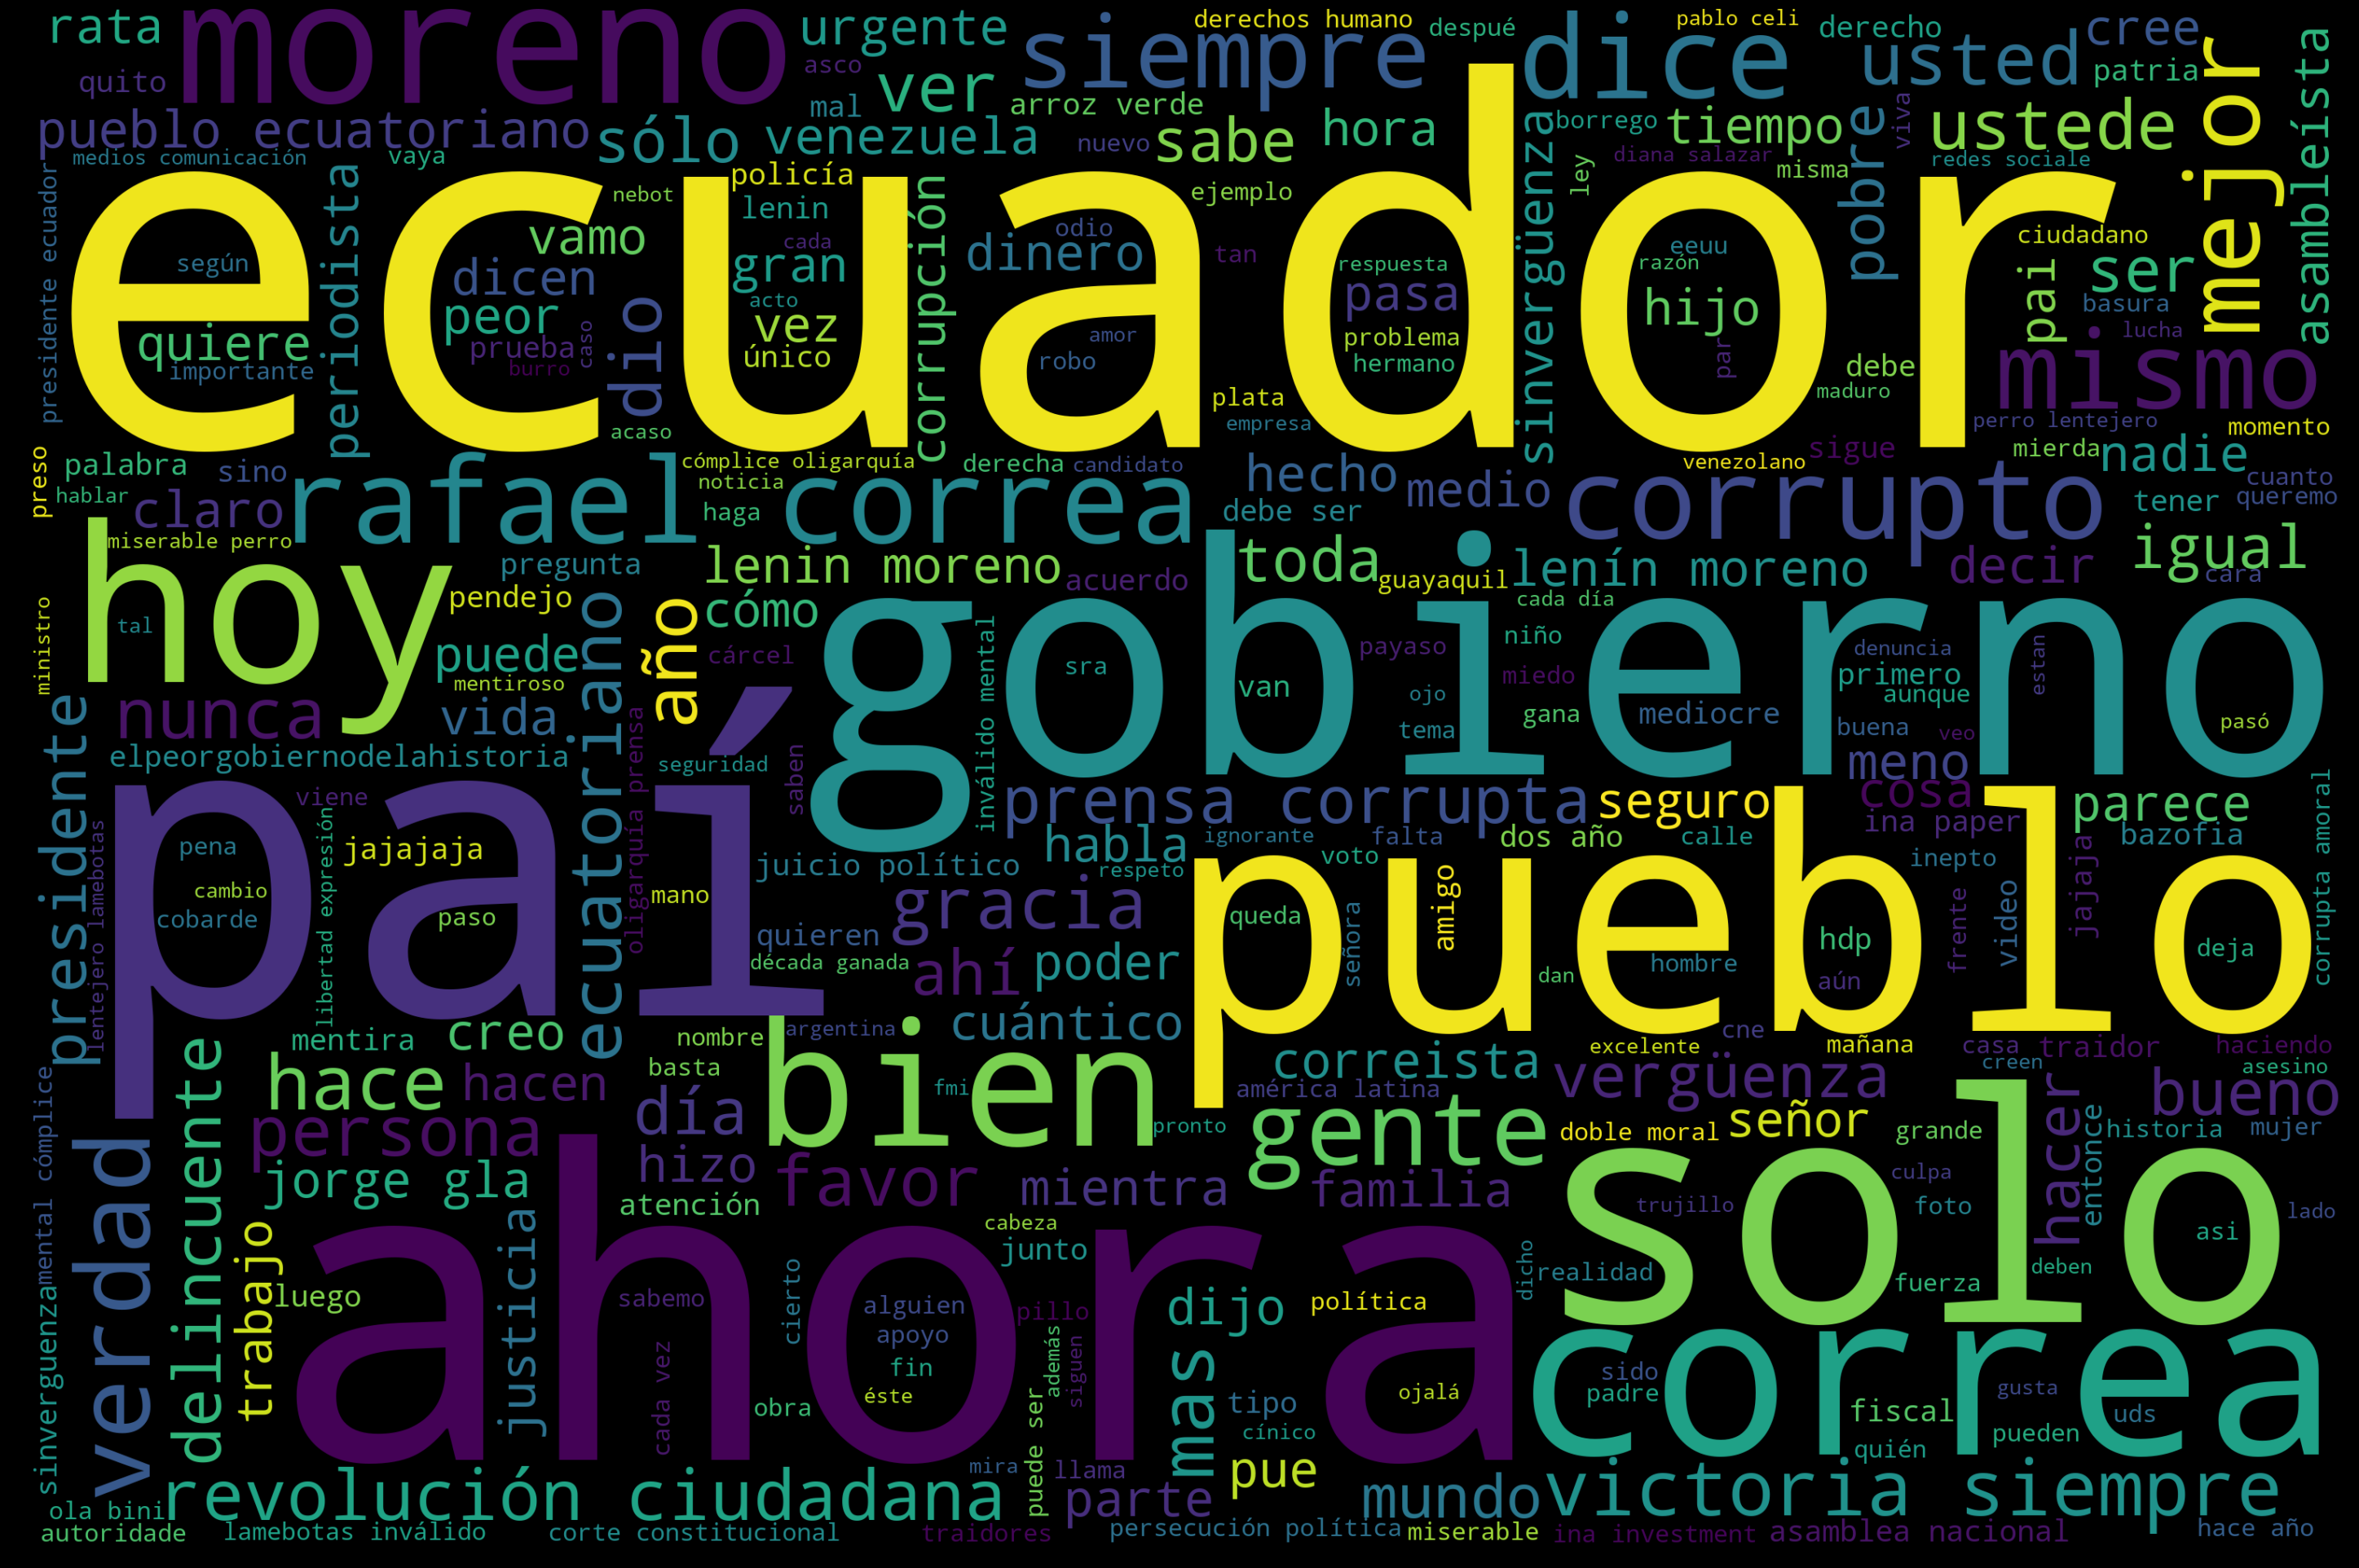

In [73]:
word_cloud(df[df["troll"] == True]["sin_stopwords"])

### 1.1Frecuencia de palabras
##### Se busca determinar cuáles palabras son la más frecuentes para usuarios troll políticos

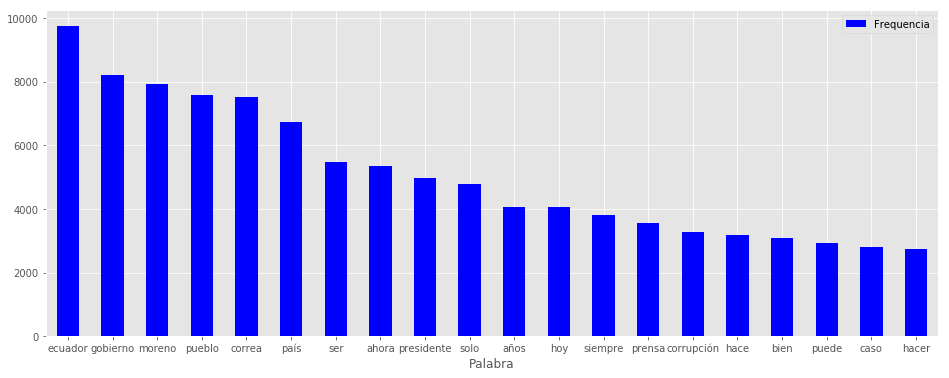

In [60]:
# se forma una sola cadena de texto de todos los textos de los tweets procesados
texto_troll = df[df["troll"] == True]["sin_stopwords"].str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
# se crea un arreglo de palabras 
palabras_troll = nltk.tokenize.word_tokenize(texto_troll, language="spanish")
distribucion = nltk.FreqDist(palabras_troll)
# histograma de las 20 palabras más frecuentes
frecuencia_troll = pd.DataFrame(distribucion.most_common(20),columns=['Palabra', 'Frequencia']).set_index('Palabra')
plt.rcParams['figure.figsize'] = [16, 6]
matplotlib.style.use('ggplot')
frecuencia_troll.plot.bar(rot=0, color="blue", ylim=(0, 10000))

### 1.2Frecuencia de emoticones
##### Se busca determinar cuáles emoticones son los más frecuentes para usuarios troll políticos

In [67]:
# se forma una sola cadena de texto de todos los textos de los tweets procesados
texto_e_troll = df[df["troll"] == True]["emoticones"].str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
# se crea un arreglo de palabras 
emoticones_troll = nltk.tokenize.word_tokenize(texto_e_troll, language="spanish")
emoticones_distribucion_troll = nltk.FreqDist(emoticones_troll)
freq_emoticon_troll = pd.DataFrame(emoticones_distribucion_troll.most_common(25),columns=['Emoticon', 'Frequencia']).set_index('Emoticon')
print("Cantidad de emoticones diferentes: " + str(len(emoticones_distribucion_troll)))
print("Top emoticones usados por troll")
for emoticon in emoticones_distribucion_troll.most_common(25):
    print(emoticon)

Cantidad de emoticones diferentes: 821
Top emoticones usados por troll
('¡', 9430)
('¿', 8298)
('\U0001f923', 3958)
('😂', 3947)
('🏼', 3778)
('️', 3028)
('👇', 2854)
('👏', 2057)
('«', 1996)
('💪', 1805)
('\u200d', 1618)
('»', 1302)
('🇪', 1280)
('🇨', 1240)
('🏻', 1211)
('♂', 1101)
('\U0001f926', 1049)
('🔴', 943)
('\u2066', 874)
('\u2069', 730)
('👍', 699)
('\U0001f92c', 679)
('🤔', 599)
('😠', 576)
('😁', 526)


### 1.3Grafo de concurrencia de palabras
##### Se busca determinar relaciones repetitivas entre palabras dentro de un mismo tweets.

In [63]:
palabras_troll = df[df["troll"] == True]["sin_stopwords"].apply(lambda t: t.strip() + " ").sum().strip()
palabras_troll_lista = nltk.wordpunct_tokenize(palabras_troll)
finder = collocations.BigramCollocationFinder.from_words(palabras_troll_lista)
measures = collocations.BigramAssocMeasures()
finder.apply_freq_filter(4) # cambiar a 2
resultado = finder.score_ngrams(measures.raw_freq)
resultado = pd.DataFrame(data=resultado, columns=['Bigram', 'Score']).set_index('Bigram').reset_index()
display(resultado.head(10000))

Bigram     Score
0                   (rafael, correa)  0.001334
1                (victoria, siempre)  0.000926
2            (revolución, ciudadana)  0.000754
3                 (prensa, corrupta)  0.000743
4              (pueblo, ecuatoriano)  0.000620
5                    (lenin, moreno)  0.000588
6                    (lenín, moreno)  0.000582
7                      (jorge, glas)  0.000553
8                 (juicio, político)  0.000420
9                        (debe, ser)  0.000389
10                     (ina, papers)  0.000386
11                    (arroz, verde)  0.000380
12                       (dos, años)  0.000368
13              (asamblea, nacional)  0.000358
14           (persecución, política)  0.000342
15                    (doble, moral)  0.000314
16                      (puede, ser)  0.000311
17                       (ola, bini)  0.000302
18             (presidente, ecuador)  0.000294
19           (corte, constitucional)  0.000291
20                 (ina, investment)  0.000285
21                      (hace, años)  0.000281
22                       (cada, vez)  0.000279
23              (oligarquía, prensa)  0.000259
24                (corrupta, amoral)  0.000255
25                (inválido, mental)  0.000255
26             (lamebotas, inválido)  0.000253
27               (derechos, humanos)  0.000241
28                 (américa, latina)  0.000239
29            (cómplice, oligarquía)  0.000239
...                              ...       ...
9970                 (grave, niegan)  0.000008
9971                 (grave, santos)  0.000008
9972               (grave, sucedido)  0.000008
9973             (gravísimo, atenta)  0.000008
9974               (grito, ipiranga)  0.000008
9975          (grupo, parlamentario)  0.000008
9976             (grupos, políticos)  0.000008
9977                (guayaquil, usd)  0.000008
9978                 (haber, dejado)  0.000008
9979                 (haber, ganado)  0.000008
9980          (haber, independencia)  0.000008
9981                 (haber, nacido)  0.000008
9982              (haber, repartido)  0.000008
9983            (habitantes, sector)  0.000008
9984             (habla, enajenados)  0.000008
9985  (hablamos, dictaduraenecuador)  0.000008
9986              (hablar, herencia)  0.000008
9987                    (hace, país)  0.000008
9988              (hace, periodismo)  0.000008
9989              (hacemos, llamado)  0.000008
9990                   (hacen, país)  0.000008
9991                (hacer, cumplir)  0.000008
9992            (hacer, desaparecer)  0.000008
9993               (hacer, gobierno)  0.000008
9994                   (hacer, país)  0.000008
9995                 (hacer, quedar)  0.000008
9996                  (hacer, viral)  0.000008
9997        (haciendo, politiquería)  0.000008
9998                   (haga, favor)  0.000008
9999                  (hagan, hagan)  0.000008

[10000 rows x 2 columns]

### 1.4CSV FINAL PARA GRAFO
#### Información necesaria para hacer el grafo de concurrencia de palabras con gephi

In [36]:
resultado['origen'] = resultado.Bigram.apply(lambda x: x[0])
resultado['destino'] = resultado.Bigram.apply(lambda x: x[1])
resultado['peso'] = resultado['Score']
resultado.drop(columns=['Bigram', 'Score'], inplace=True)
resultado.head(100)[["origen","destino","peso"]].to_csv('dataset/grafo_data_troll.csv', index=False)

## 2. Análisis usuarios no troll

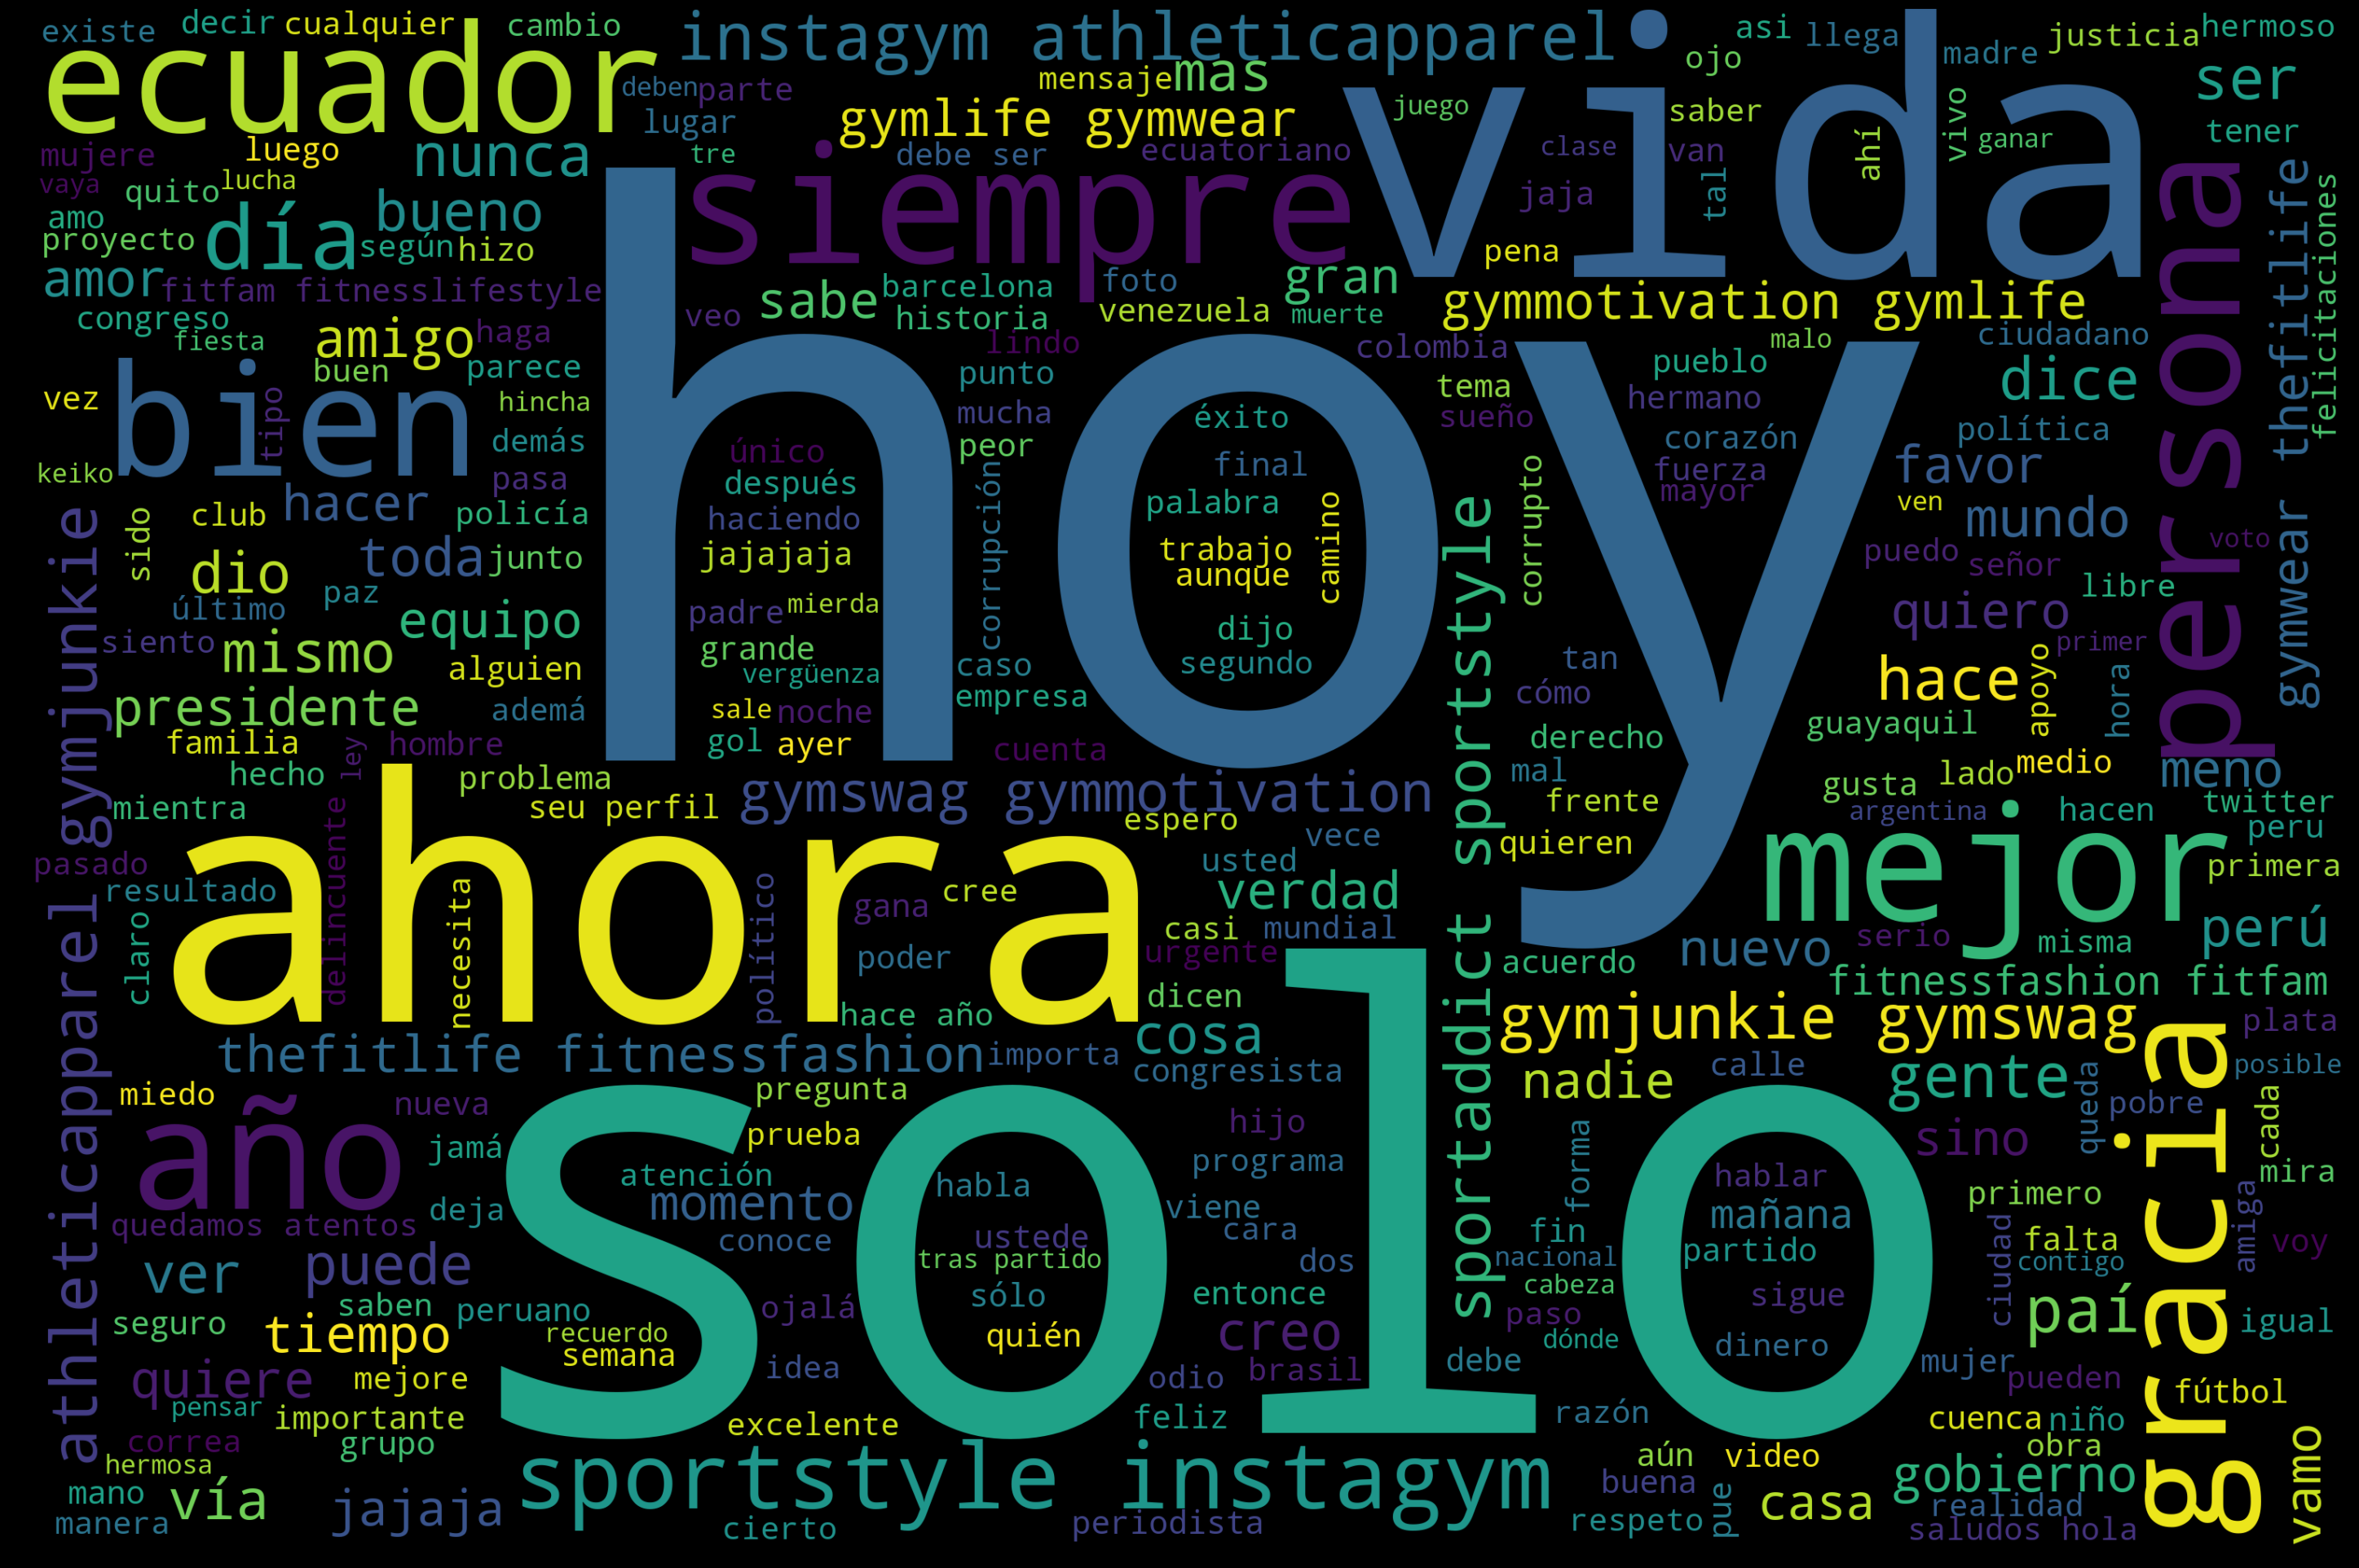

In [74]:
word_cloud(df[df["troll"] == False]["sin_stopwords"])

### 2.1Frecuencia de palabras
##### Se busca determinar cuáles palabras son la más frecuentes para usuarios troll políticos

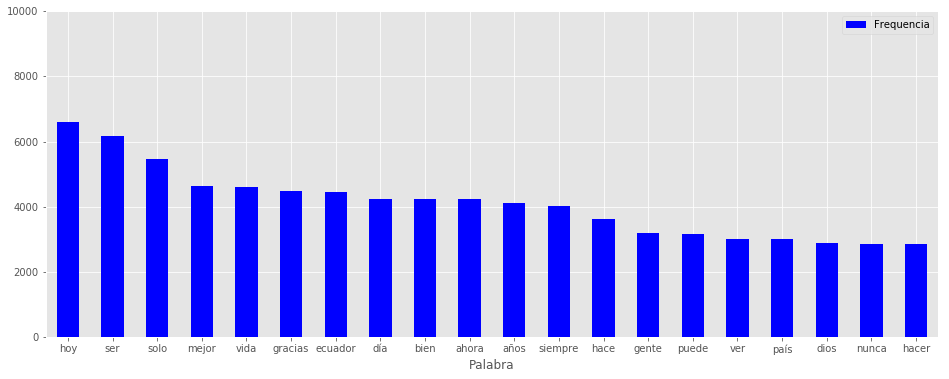

In [22]:
# se forma una sola cadena de texto de todos los textos de los tweets procesados
texto_ntroll = df[df["troll"] == False]["sin_stopwords"].str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
# se crea un arreglo de palabras 
palabras_ntroll = nltk.tokenize.word_tokenize(texto_ntroll, language="spanish")
distribucion = nltk.FreqDist(palabras_ntroll)
frecuencia_ntroll = pd.DataFrame(distribucion.most_common(20),columns=['Palabra', 'Frequencia']).set_index('Palabra')
plt.rcParams['figure.figsize'] = [16, 6]
matplotlib.style.use('ggplot')
frecuencia_ntroll.plot.bar(rot=0, color="blue", ylim=(0, 10000))

### 2.2Frecuencia de emoticones
##### Se busca determinar cuáles emoticones son los más frecuentes para usuarios no troll

In [69]:
texto_e_ntroll = df[df["troll"] == False]["emoticones"].str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
emoticones_ntroll = nltk.tokenize.word_tokenize(texto_e_ntroll, language="spanish")
emoticones_distribucion_ntroll = nltk.FreqDist(emoticones_ntroll)
freq_emoticon_ntroll = pd.DataFrame(emoticones_distribucion_ntroll.most_common(25),columns=['Emoticon', 'Frequencia']).set_index('Emoticon')
print("Cantidad de emoticones diferentes: " + str(len(emoticones_distribucion_ntroll)))
print("Top emoticones usados por no troles")
for emoticon in emoticones_distribucion_ntroll.most_common(25):
    print(emoticon)

Cantidad de emoticones diferentes: 1292
Top emoticones usados por no troles
('️', 9311)
('¿', 9034)
('¡', 8466)
('😂', 6492)
('😍', 5502)
('\U0001f923', 4641)
('❤', 4539)
('🏻', 3122)
('👏', 2823)
('\u200d', 2617)
('🇪', 2342)
('🇨', 2279)
('💪', 2097)
('😭', 1907)
('🏼', 1848)
('\U0001f937', 1628)
('✨', 1385)
('►', 1383)
('♂', 1340)
('▶', 1329)
('💛', 1325)
('🙏', 1269)
('😎', 1236)
('🙌', 1221)
('・', 1196)


### 2.3Grafo de concurrencia de palabras
##### Se busca determinar relaciones repetitivas entre palabras dentro de un mismo tweets.

In [100]:
palabras_ntroll = df[df["troll"] == False]["sin_stopwords"].apply(lambda t: t.strip() + " ").sum().strip()
palabras_ntroll_lista = nltk.wordpunct_tokenize(palabras_ntroll)
finder = collocations.BigramCollocationFinder.from_words(palabras_ntroll_lista)
measures = collocations.BigramAssocMeasures()
finder.apply_freq_filter(4) # cambiar a 2
resultado_ntroll = finder.score_ngrams(measures.raw_freq)
resultado_ntroll = pd.DataFrame(data=resultado_ntroll, columns=['Bigram', 'Score']).set_index('Bigram').reset_index()
display(resultado.head(10000))

Bigram     Score
0                   (rafael, correa)  0.001334
1                (victoria, siempre)  0.000926
2            (revolución, ciudadana)  0.000754
3                 (prensa, corrupta)  0.000743
4              (pueblo, ecuatoriano)  0.000620
5                    (lenin, moreno)  0.000588
6                    (lenín, moreno)  0.000582
7                      (jorge, glas)  0.000553
8                 (juicio, político)  0.000420
9                        (debe, ser)  0.000389
10                     (ina, papers)  0.000386
11                    (arroz, verde)  0.000380
12                       (dos, años)  0.000368
13              (asamblea, nacional)  0.000358
14           (persecución, política)  0.000342
15                    (doble, moral)  0.000314
16                      (puede, ser)  0.000311
17                       (ola, bini)  0.000302
18             (presidente, ecuador)  0.000294
19           (corte, constitucional)  0.000291
20                 (ina, investment)  0.000285
21                      (hace, años)  0.000281
22                       (cada, vez)  0.000279
23              (oligarquía, prensa)  0.000259
24                (corrupta, amoral)  0.000255
25                (inválido, mental)  0.000255
26             (lamebotas, inválido)  0.000253
27               (derechos, humanos)  0.000241
28                 (américa, latina)  0.000239
29            (cómplice, oligarquía)  0.000239
...                              ...       ...
9970                 (grave, niegan)  0.000008
9971                 (grave, santos)  0.000008
9972               (grave, sucedido)  0.000008
9973             (gravísimo, atenta)  0.000008
9974               (grito, ipiranga)  0.000008
9975          (grupo, parlamentario)  0.000008
9976             (grupos, políticos)  0.000008
9977                (guayaquil, usd)  0.000008
9978                 (haber, dejado)  0.000008
9979                 (haber, ganado)  0.000008
9980          (haber, independencia)  0.000008
9981                 (haber, nacido)  0.000008
9982              (haber, repartido)  0.000008
9983            (habitantes, sector)  0.000008
9984             (habla, enajenados)  0.000008
9985  (hablamos, dictaduraenecuador)  0.000008
9986              (hablar, herencia)  0.000008
9987                    (hace, país)  0.000008
9988              (hace, periodismo)  0.000008
9989              (hacemos, llamado)  0.000008
9990                   (hacen, país)  0.000008
9991                (hacer, cumplir)  0.000008
9992            (hacer, desaparecer)  0.000008
9993               (hacer, gobierno)  0.000008
9994                   (hacer, país)  0.000008
9995                 (hacer, quedar)  0.000008
9996                  (hacer, viral)  0.000008
9997        (haciendo, politiquería)  0.000008
9998                   (haga, favor)  0.000008
9999                  (hagan, hagan)  0.000008

[10000 rows x 2 columns]

### 2.4CSV FINAL PARA GRAFO
#### Información necesaria para hacer el grafo de concurrencia de palabras con gephi

In [101]:
resultado_ntroll['origen'] = resultado_ntroll.Bigram.apply(lambda x: x[0])
resultado_ntroll['destino'] = resultado_ntroll.Bigram.apply(lambda x: x[1])
resultado_ntroll['peso'] = resultado_ntroll['Score']http://localhost:8888/notebooks/AED/AED/proyecto.ipynb#3.-An%C3%A1lisis-de-sentimientos-de-los-tweets
resultado_ntroll.drop(columns=['Bigram', 'Score'], inplace=True)
resultado_ntroll.head(100)[["origen","destino","peso"]].to_csv('dataset/grafo_data_ntroll.csv', index=False)

## 3. Análisis de sentimientos de los tweets
### Se obtuvo la polaridad de cada tweets usando la librería textblob

In [5]:
df['polarity'] = df["content"].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

In [6]:
df

content followers  \
author                                                                         
Christi98823048  @MashiRafael Asustado te veo ladrón! Irás a la...         0   
Christi98823048  @MashiRafael La década saqueada y robada maldi...         0   
Christi98823048  @Guaytamba_LDU @LDU_Oficial Genial! Hablamos p...         0   
Christi98823048  @MashiRafael Cárcel para todos los alcahuetes ...         0   
Christi98823048  @MashiRafael Ya valió el Liverpool gracias al ...         0   
Christi98823048      @MashiRafael Ahí es donde vas a parar LADRÓN!         0   
Christi98823048  @MashiRafael Traduce tu mismo! Eres una bestia...         0   
Christi98823048  @MashiRafael Y el abuso de justicia y poder qu...         0   
Christi98823048  @MashiRafael Cuando te "sacrificas" tu?? El Ec...         0   
Christi98823048  @MashiRafael Lo que queremos es que tu acabes ...         0   
Christi98823048  @MashiRafael Década robada y manipulada. Fuist...         0   
Christi98823048  @lejandoors @MashiRafael @LuisaMaldonadoM @rel...         0   
Christi98823048  @MashiRafael Querrás decir a seguir robando la...         0   
Christi98823048  @MashiRafael Entonces xq no vienes a Ecuador y...         0   
Christi98823048  @MashiRafael Quieren recuperar la patria? o es...         0   
Christi98823048  @MashiRafael Y todos los milloncitos que Tú! Y...         0   
Christi98823048  @MashiRafael Me suena a que te describes a sí ...         0   
Christi98823048  @MashiRafael Ladrón! También deberías estar en...         0   
Christi98823048  RT @luisevivanco: Leo una avalancha de curuchu...         0   
Christi98823048       @MashiRafael Ladrón! Prófugo de la justicia!         0   
Leonard36262814  @MashiRafael Pero como los van a encontrar; a ...         0   
Leonard36262814  @MashiRafael El que deberia ir preso es usted ...         0   
Leonard36262814  @MashiRafael Cuanto le habra ofrecido para que...         0   
Leonard36262814  @MashiRafael Que sinismo al decir eso o se olv...         0   
Leonard36262814  @MashiRafael Que sinismo! De que dinero invert...         0   
Leonard36262814  @MashiRafael Sinico sinverguenza al decir eso ...         0   
Leonard36262814  @MashiRafael Que sinismo al hablar de quien ti...         0   
Leonard36262814       @MashiRafael Inmoral https://t.co/gDTj5KzneD         0   
Leonard36262814  @MashiRafael El ex vicepresidente y si esta ha...         0   
Leonard36262814                                   @MashiRafael 🐀🐀🐀         0   
...                                                            ...       ...   
DelPatibulo      RT @cristiancrespoj: Más medicina de guerra en...       156   
DelPatibulo      RT @jguaido: Estamos en recorrido revisando la...       156   
DelPatibulo      RT @cristiancrespoj: Medicina de guerra en #Ve...       156   
DelPatibulo      RT @cristiancrespoj: Caos por el transporte en...       156   
DelPatibulo      El caos en Venezuela no hay agua no hay luz no...       156   
DelPatibulo      RT @maryorinmendez: Ante la gravedad del asunt...       156   
DelPatibulo      El exitoso modelo del socialismo del siglo 21 ...       156   
DelPatibulo      RT @ProanoMaya: La mujer es un gran corazón. N...       156   
DelPatibulo      RT @alperezs: Paco "Tababela" Moncayo en Quito...       156   
DelPatibulo      @mbachelet Cállate y mueve tus nalgas y anda v...       156   
DelPatibulo      RT @jguaido: Saboteo es robarse el dinero de l...       156   
DelPatibulo      RT @AllanRowen: Entrenando para ser Correista!...       156   
DelPatibulo      RT @momentoviral: - Un extraño le tocó sin raz...       156   
DelPatibulo      RT @jguaido: 11 PM.   22 estados sin luz.   6 ...       156   
DelPatibulo      RT @jguaido: Tenemos El Guri; Tocoma y Caruach...       156   
DelPatibulo      Los mahuadistas que pactaron con el correismo ...       156   
DelPatibulo      RT @teleamazonasec: Madre de hijos drogadictos...       156   
DelPatibulo      @amandaasubiar @ArboledaJC1983 Imbecil por

In [7]:
df.to_csv('alldataset_sentimental.csv')

### 3.1 Distribución de la polaridad de tweets de usuarios troll

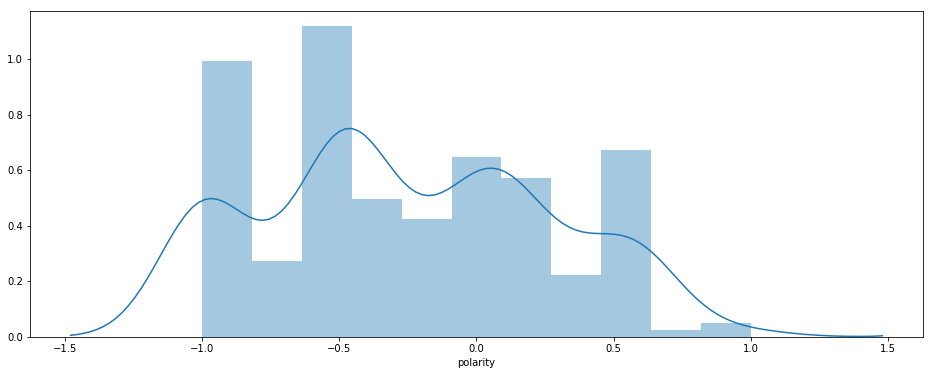

In [7]:
plt.rcParams['figure.figsize'] = [16, 6]
df_lat = df[(df["polarity"]>0.01) | (df["polarity"]<-0.01)]
sns.distplot(df_lat[df_lat["troll"]==True]["polarity"])

### 3.2 Distribución de la polaridad de tweets de usuarios no troll

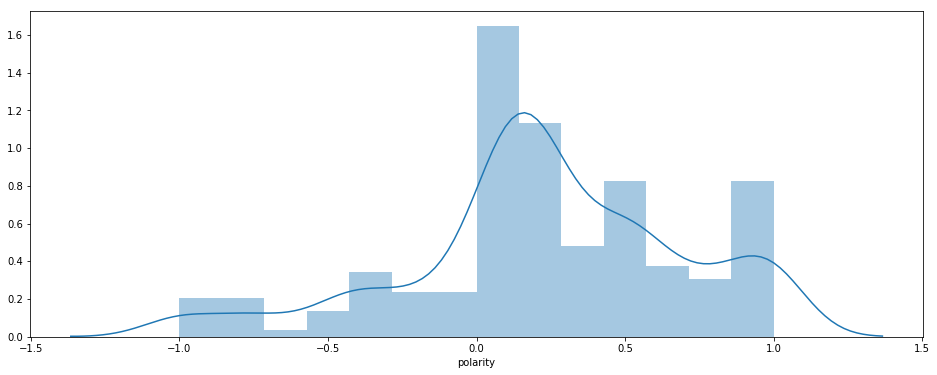

In [8]:
sns.distplot(df_lat[df_lat["troll"]==False]["polarity"])

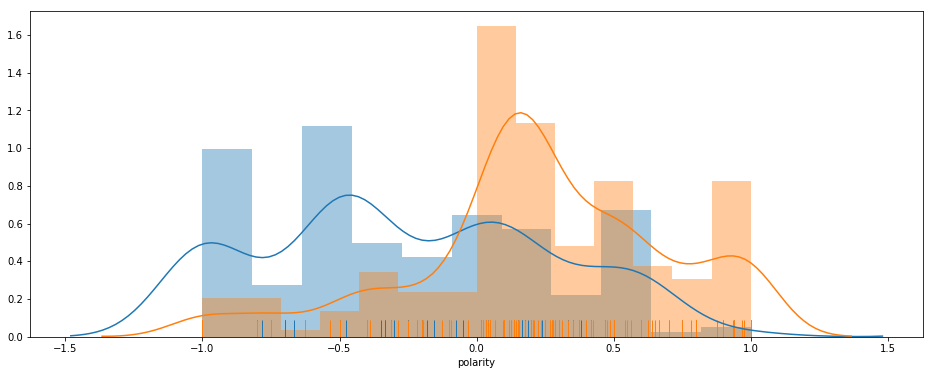

In [9]:
sns.distplot(df_lat[df_lat["troll"]==True]["polarity"], rug=True)
sns.distplot(df_lat[df_lat["troll"]==False]["polarity"], rug=True)

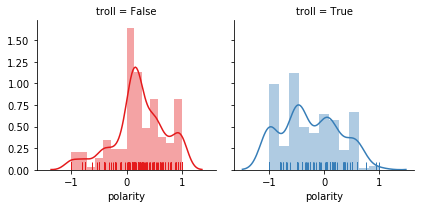

In [11]:
g = sns.FacetGrid(df_lat, col='troll', hue="troll", palette="Set1")
g = (g.map(sns.distplot, "polarity", rug=True))

### 3.3 Promedio de la polaridad de tweets por tipo de usuario

In [12]:
df_prome = df_lat[["troll","polarity"]].groupby(df_lat["troll"]).mean()
df_prome

polarity
troll          
False  0.229124
True  -0.251557

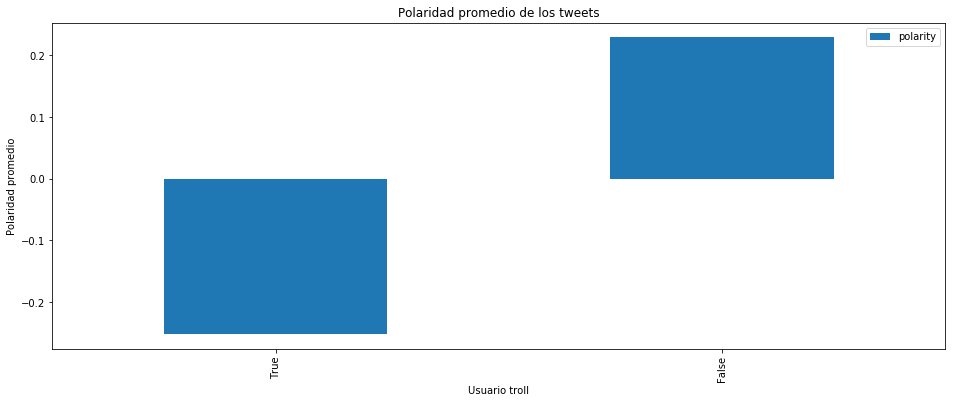

In [13]:
usuarios = df_prome.sort_values('polarity',ascending = True)
ax =usuarios.plot(kind='bar', title="Polaridad promedio de los tweets")
ax.set(ylabel='Polaridad promedio', xlabel='Usuario troll')
plt.show()

## 4.Distribución de los datos y análisis de variables/features

In [47]:
df = pd.read_csv('alldataset_sentimental.csv', sep=",", encoding='utf-8')
users_copy = df[df["troll"] == False].copy()
trolls_copy =  df[df["troll"] == True].copy()
users_copy['created_at'] = users_copy['created_at'].apply(pd.to_datetime)
trolls_copy['created_at'] = trolls_copy['created_at'].apply(pd.to_datetime)
df['created_at'] = df['created_at'].apply(pd.to_datetime)
n = 10000

In [36]:
troll_range = trolls_copy[
    (trolls_copy.created_at >= '2019-01-01') &
    (trolls_copy.created_at <= '2019-08-10')]

users_range = users_copy[
    (users_copy.created_at >= '2019-01-01') &
    (users_copy.created_at <= '2019-08-10')]

### 4.1 Análisis de los tweets del último año generado por usuarios no troll y trolls.

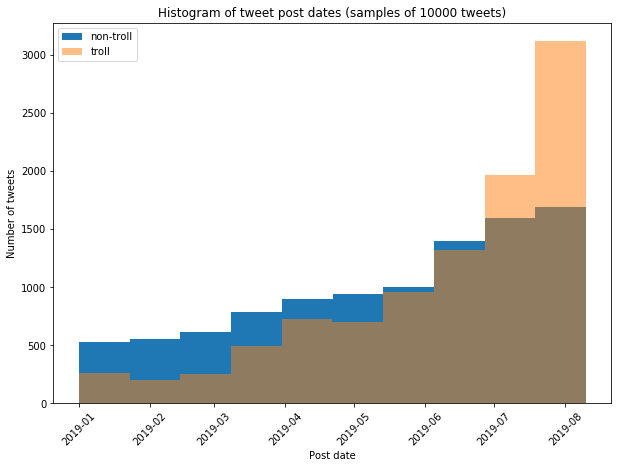

In [37]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.set_title('Histogram of tweet post dates (samples of 10000 tweets)')
ax.set_ylabel('Number of tweets')
ax.set_xlabel('Post date')

nontroll_dates = users_range.created_at.sample(n)
troll_dates = troll_range.created_at.sample(n)

ax.hist(nontroll_dates, bins=10, label='non-troll')
ax.hist(troll_dates, bins=10, label='troll', alpha=0.5)

ax.legend()
ax.tick_params(axis='x', rotation=45)

# ### 4.2Followers

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
fig.tight_layout()

ax.set_title('Histogram of followers (samples of 100K tweets)')
ax.set_ylabel('Log Density')
ax.set_xlabel('Number of followers (x $10^7$)')

troll_followers = trolls_copy.followers.sample(n)
nontroll_followers = users_copy.followers.sample(n)

ax.hist(troll_followers, bins=100, label='troll', density=True, log=True)
ax.hist(nontroll_followers, bins=100, label='non-troll', density=True, log=True, alpha=0.2)

ax.legend()
plt.show()

# ### 4.3Following

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.set_title('Histogram of following (samples of 1000 tweets)')
ax.set_ylabel('Density')
ax.set_xlabel('Number of following')
trolls_copy.following.hist(ax=ax, bins=100, label='troll', color='blue', alpha=1, density=True)
users_copy.following.hist(ax=ax, bins=100, label='non-troll', color='orange', alpha=0.5, density=True)
ax.set_xlim(0, 1000)
ax.legend()
plt.show()

# #4.4Posts dates distribution

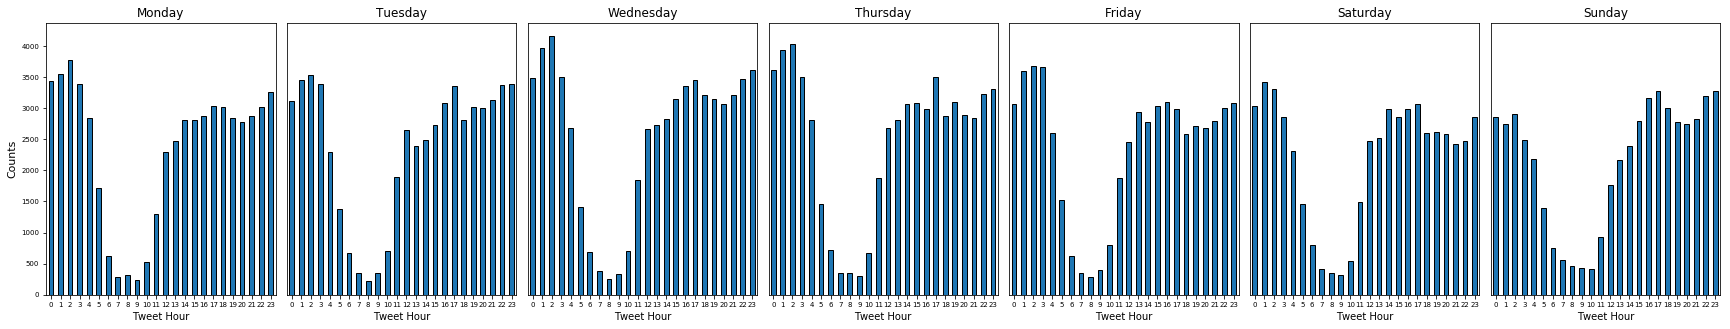

In [48]:
# ### All users interactions
fig, ax = plt.subplots(ncols=7, figsize=(30,5))
plt.subplots_adjust(wspace=0.05)  #Remove some whitespace between subplots

for idx, gp in df.groupby(df['created_at'].dt.dayofweek):
    ax[int(idx)].set_title(gp['created_at'].dt.day_name().iloc[0])  #Set title to the weekday

    (gp.groupby(gp['created_at'].dt.hour).size().rename_axis('Tweet Hour').to_frame('')
        .reindex(np.arange(0,24,1)).fillna(0)
        .plot(kind='bar', ax=ax[int(idx)], rot=0, ec='k', legend=False))

    # Ticks and labels on leftmost only
    if idx == 0:
        _ = ax[int(idx)].set_ylabel('Counts', fontsize=11)

    _ = ax[int(idx)].tick_params(axis='both', which='major', labelsize=7,
                            labelleft=(idx == 0), left=(idx == 0))

# Consistent bounds between subplots. 
lb, ub = list(zip(*[axis.get_ylim() for axis in ax]))
for axis in ax:
    axis.set_ylim(min(lb), max(ub)) 

plt.show()

# ### 4.5Trolls interactions by day

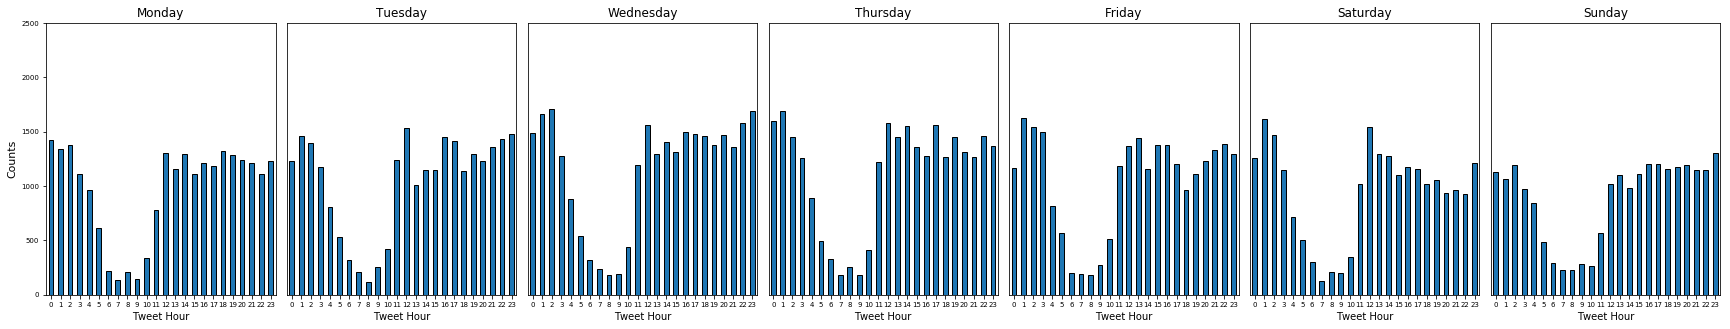

In [52]:
fig, ax = plt.subplots(ncols=7, figsize=(30,5))
plt.subplots_adjust(wspace=0.05)  #Remove some whitespace between subplots

for idx, gp in df.groupby(trolls_copy['created_at'].dt.dayofweek):
    ax[int(idx)].set_title(gp['created_at'].dt.day_name().iloc[0])  #Set title to the weekday

    (gp.groupby(gp['created_at'].dt.hour).size().rename_axis('Tweet Hour').to_frame('')
        .reindex(np.arange(0,24,1)).fillna(0)
        .plot(kind='bar', ax=ax[int(idx)], rot=0, ec='k', legend=False))

    # Ticks and labels on leftmost only
    if idx == 0:
        _ = ax[int(idx)].set_ylabel('Counts', fontsize=11)

    _ = ax[int(idx)].tick_params(axis='both', which='major', labelsize=7,
                            labelleft=(idx == 0), left=(idx == 0))

# Consistent bounds between subplots. 
lb, ub = list(zip(*[axis.get_ylim() for axis in ax]))
for axis in ax:
    axis.set_ylim(min(lb), 2500) 

plt.show()

# ### 4.6No trolls interactions by day

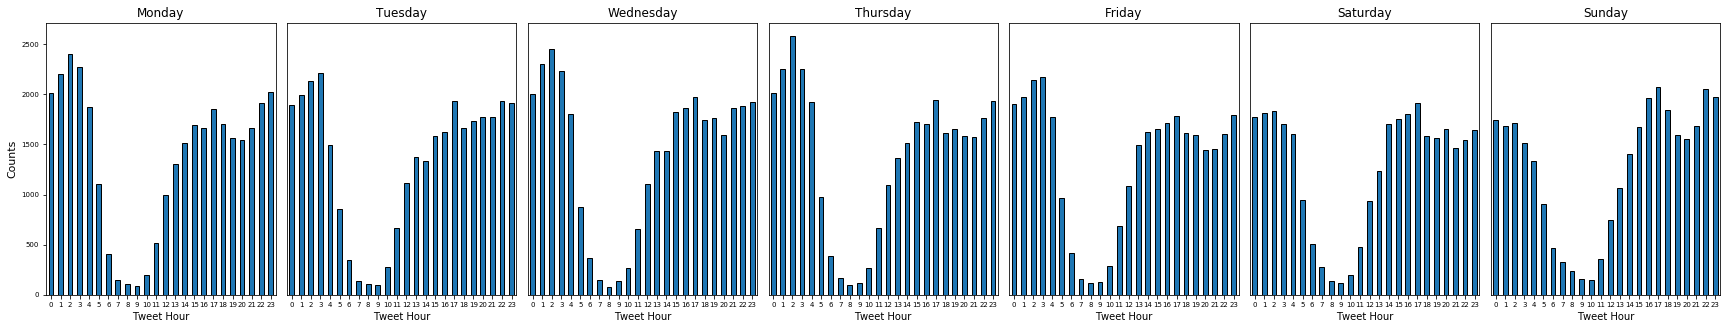

In [50]:
fig, ax = plt.subplots(ncols=7, figsize=(30,5))
plt.subplots_adjust(wspace=0.05)  #Remove some whitespace between subplots

for idx, gp in df.groupby(users_copy['created_at'].dt.dayofweek):
    ax[int(idx)].set_title(gp['created_at'].dt.day_name().iloc[0])  #Set title to the weekday

    (gp.groupby(gp['created_at'].dt.hour).size().rename_axis('Tweet Hour').to_frame('')
        .reindex(np.arange(0,24,1)).fillna(0)
        .plot(kind='bar', ax=ax[int(idx)], rot=0, ec='k', legend=False))

    # Ticks and labels on leftmost only
    if idx == 0:
        _ = ax[int(idx)].set_ylabel('Counts', fontsize=11)

    _ = ax[int(idx)].tick_params(axis='both', which='major', labelsize=7,
                            labelleft=(idx == 0), left=(idx == 0))

# Consistent bounds between subplots. 
lb, ub = list(zip(*[axis.get_ylim() for axis in ax]))
for axis in ax:
    axis.set_ylim(min(lb), max(ub)) 

plt.show()

# ### 4.7Retweets 

/media/mdleiton/Respaldo/repositorios/AED/env/lib/python3.5/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/media/mdleiton/Respaldo/repositorios/AED/env/lib/python3.5/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


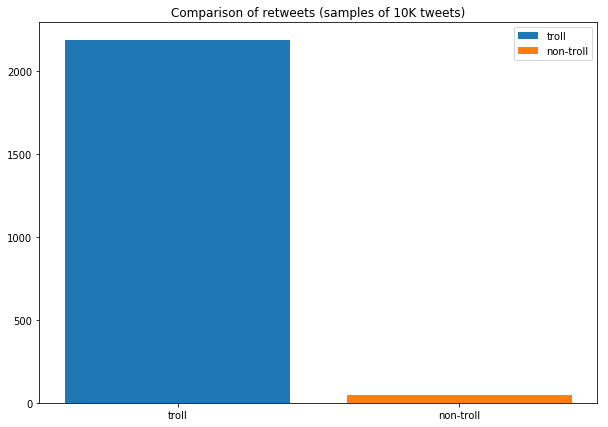

In [63]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.set_title('Comparison of retweets (samples of 10K tweets)')

troll_retweets = trolls_copy.sample(10000)[trolls_copy['retweet'] ==  True]['retweet'].count()
nontroll_retweets = users_copy.sample(10000)[users_copy['retweet'] ==  True]['retweet'].count()

ax.bar(['troll'],troll_retweets,label='troll')
ax.bar(['non-troll'],nontroll_retweets,label='non-troll')

ax.legend()
plt.show()

# ### 4.8 Links

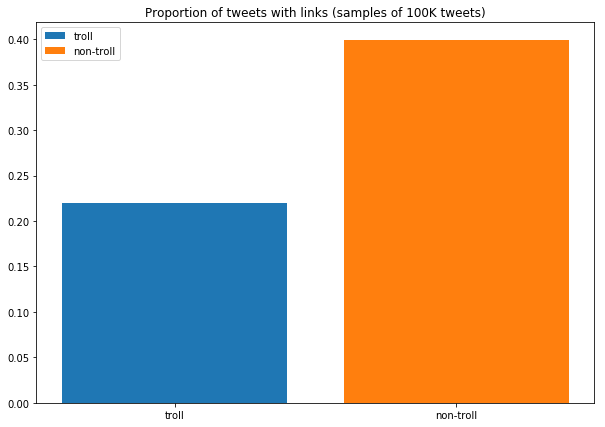

In [65]:
def has_link(text):
    return 't.co' in text

def compute_link_percentage(df, text_column_name):
    vc = df[text_column_name].aggregate(has_link).value_counts()
    return vc[True]/(vc[True] + vc[False])

link_percentage_troll = compute_link_percentage(trolls_copy, 'content')
link_percentage_non_troll = compute_link_percentage(users_copy, 'content')

fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.set_title('Proportion of tweets with links (samples of 100K tweets)')

ax.bar(['troll'],link_percentage_troll,label='troll')
ax.bar(['non-troll'],link_percentage_non_troll,label='non-troll')

ax.legend()
plt.show()

# 5.1 Parrot Metric

In [72]:
def parrot_emotion_model(text):
    sp = SenticPhrase(text, "es")
    emotions = {"fear": 0, "anger": 0, "sadness": 0, "love": 0, "surprise": 0, "joy": 0}
    # Parrot emotion model
    if sp.get_sentics():
        sentic_dict = sp.get_sentics()
        emotions["fear"] += 1 if -0.3 > sentic_dict["sensitivity"] >= -0.6 else 0
        emotions["anger"] += 1 if 0.6 >= sentic_dict["sensitivity"] > 0.3 else 0
        emotions["sadness"] +=1  if -0.3 > sentic_dict["pleasantness"] >= -0.6 else 0
        emotions["love"] +=1  if sentic_dict["pleasantness"] > 0 and sentic_dict["aptitude"] > 0 else 0
        emotions["surprise"] += 1 if -0.3 > sentic_dict["attention"] >= -0.6 else 0
        emotions["joy"] += 1 if 0.6 >= sentic_dict["pleasantness"] > 0.3 else 0
    return emotions

In [74]:
df["parrot"] = df.apply(axis=1, func= lambda x: parrot_emotion_model(str(x["content"])))

In [75]:
df["parrot"]

0         {'joy': 0, 'fear': 0, 'love': 0, 'sadness': 0,...
1         {'joy': 0, 'fear': 0, 'love': 0, 'sadness': 0,...
2         {'joy': 0, 'fear': 0, 'love': 0, 'sadness': 0,...
3         {'joy': 0, 'fear': 0, 'love': 0, 'sadness': 0,...
4         {'joy': 0, 'fear': 0, 'love': 0, 'sadness': 0,...
5         {'joy': 0, 'fear': 0, 'love': 0, 'sadness': 0,...
6         {'joy': 0, 'fear': 0, 'love': 0, 'sadness': 1,...
7         {'joy': 0, 'fear': 0, 'love': 1, 'sadness': 0,...
8         {'joy': 0, 'fear': 0, 'love': 0, 'sadness': 0,...
9         {'joy': 0, 'fear': 0, 'love': 0, 'sadness': 0,...
10        {'joy': 0, 'fear': 0, 'love': 0, 'sadness': 0,...
11        {'joy': 0, 'fear': 0, 'love': 1, 'sadness': 0,...
12        {'joy': 0, 'fear': 0, 'love': 0, 'sadness': 0,...
13        {'joy': 0, 'fear': 0, 'love': 1, 'sadness': 0,...
14        {'joy': 0, 'fear': 0, 'love': 0, 'sadness': 0,...
15        {'joy': 0, 'fear': 0, 'love': 1, 'sadness': 0,...
16        {'joy': 0, 'fear': 0, 'love': 

# 5,1 vader sentiment

In [78]:
def vader_sentiment(text):
    """
        Return 1 if positive, -1 to negative and 0 to neutral
    """
    # Vader Sentiment analyzer and languages for translator
    sid_obj = SentimentIntensityAnalyzer()
    to_lang="en"  
    from_lang="es"
    # please note usage limits for My Memory Translation Service:   http://mymemory.translated.net/doc/usagelimits.php
    # using   MY MEMORY NET   http://mymemory.translated.net
    api_url = "http://mymemory.translated.net/api/get?q={}&langpair={}|{}".format(text, from_lang, to_lang)
    hdrs ={'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
           'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
           'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
           'Accept-Encoding': 'none',
           'Accept-Language': 'en-US,en;q=0.8',
           'Connection': 'keep-alive'}
    response = requests.get(api_url, headers=hdrs)
    response_json = json.loads(response.text)
    translation = response_json["responseData"]["translatedText"]
    translator_name = "MemoryNet Translation Service"
    
    # polarity_scores method of SentimentIntensityAnalyzer 
    # oject gives a sentiment dictionary. 
    # which contains pos, neg, neu, and compound scores. 
    sentiment_dict = sid_obj.polarity_scores(translation)   
    if sentiment_dict['compound'] >= 0.05 : 
        return 1
    elif sentiment_dict['compound'] <= - 0.05 : 
        return -1
    else : 
        return 0

In [80]:
df["vader_sentiment"] = df.apply(axis=1, func= lambda x: vader_sentiment(str(x["content"])))
df

author                                            content  \
0       Christi98823048  @MashiRafael Asustado te veo ladrón! Irás a la...   
1       Christi98823048  @MashiRafael La década saqueada y robada maldi...   
2       Christi98823048  @Guaytamba_LDU @LDU_Oficial Genial! Hablamos p...   
3       Christi98823048  @MashiRafael Cárcel para todos los alcahuetes ...   
4       Christi98823048  @MashiRafael Ya valió el Liverpool gracias al ...   
5       Christi98823048      @MashiRafael Ahí es donde vas a parar LADRÓN!   
6       Christi98823048  @MashiRafael Traduce tu mismo! Eres una bestia...   
7       Christi98823048  @MashiRafael Y el abuso de justicia y poder qu...   
8       Christi98823048  @MashiRafael Cuando te "sacrificas" tu?? El Ec...   
9       Christi98823048  @MashiRafael Lo que queremos es que tu acabes ...   
10      Christi98823048  @MashiRafael Década robada y manipulada. Fuist...   
11      Christi98823048  @lejandoors @MashiRafael @LuisaMaldonadoM @rel...   
12      Christi98823048  @MashiRafael Querrás decir a seguir robando la...   
13      Christi98823048  @MashiRafael Entonces xq no vienes a Ecuador y...   
14      Christi98823048  @MashiRafael Quieren recuperar la patria? o es...   
15      Christi98823048  @MashiRafael Y todos los milloncitos que Tú! Y...   
16      Christi98823048  @MashiRafael Me suena a que te describes a sí ...   
17      Christi98823048  @MashiRafael Ladrón! También deberías estar en...   
18      Christi98823048  RT @luisevivanco: Leo una avalancha de curuchu...   
19      Christi98823048       @MashiRafael Ladrón! Prófugo de la justicia!   
20      Leonard36262814  @MashiRafael Pero como los van a encontrar; a ...   
21      Leonard36262814  @MashiRafael El que deberia ir preso es usted ...   
22      Leonard36262814  @MashiRafael Cuanto le habra ofrecido para que...   
23      Leonard36262814  @MashiRafael Que sinismo al decir eso o se olv...   
24      Leonard36262814  @MashiRafael Que sinismo! De que dinero invert...   
25      Leonard36262814  @MashiRafael Sinico sinverguenza al decir eso ...   
26      Leonard36262814  @MashiRafael Que sinismo al hablar de quien ti...   
27      Leonard36262814       @MashiRafael Inmoral https://t.co/gDTj5KzneD   
28      Leonard36262814  @MashiRafael El ex vicepresidente y si esta ha...   
29      Leonard36262814                                   @MashiRafael 🐀🐀🐀   
...                 ...                                                ...   
395119      DelPatibulo  RT @cristiancrespoj: Más medicina de guerra en...   
395120      DelPatibulo  RT @jguaido: Estamos en recorrido revisando la...   
395121      DelPatibulo  RT @cristiancrespoj: Medicina de guerra en #Ve...   
395122      DelPatibulo  RT @cristiancrespoj: Caos por el transporte en...   
395123      DelPatibulo  El caos en Venezuela no hay agua no hay luz no...   
395124      DelPatibulo  RT @maryorinmendez: Ante la gravedad del asunt...   
395125      DelPatibulo  El exitoso modelo del socialismo del siglo 21 ...   
395126      DelPatibulo  RT @ProanoMaya: La mujer es un gran corazón. N...   
395127      DelPatibulo  RT @alperezs: Paco "Tababela" Moncayo en Quito...   
395128      DelPatibulo  @mbachelet Cállate y mueve tus nalgas y anda v...   
395129      DelPatibulo  RT @jguaido: Saboteo es robarse el dinero de l...   
395130      DelPatibulo  RT @AllanRowen: Entrenando para ser Correista!...   
395131      DelPatibulo  RT @momentoviral: - Un extraño le tocó sin raz...   
395132      DelPatibulo  RT @jguaido: 11 PM.   22 estados sin luz.   6 ...   
395133      DelPatibulo  RT @jguaido: Tenemos El Guri; Tocoma y Caruach...   
395134      DelPatibulo  Los mahuadistas que pactaron con el correismo ...   
395135      DelPatibulo  RT @teleamazonasec: Madre de hijos drogadictos...   
395136      DelPatibulo  @amandaasubiar @ArboledaJC1983 Imbecil por que...   
395137      DelPatibulo  @PabloDavilaJ Evidente el favoritismo a Salaza...   
395138      DelPatibulo  @PedritoExtran

In [ ]:
df = pd.read_csv('alldataset_sentimental.csv', sep=",", encoding='utf-8')

# 6. Clustering

In [82]:
### Standarize followers/following
scaler = preprocessing.StandardScaler().fit(df[['followers','following']])
'rand means and scales: {}, {}'.format(scaler.mean_, scaler.scale_)

'rand means and scales: [1605.77704752  770.3008089 ], [13516.84299765  1975.23207444]'

In [89]:
col_to_std = ['followers', 'following']
df_k =  df
df_k[col_to_std]=scaler.transform(df_k[col_to_std])

/media/mdleiton/Respaldo/repositorios/AED/env/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/media/mdleiton/Respaldo/repositorios/AED/env/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [90]:
bool_to_bin = lambda x: 1 if x else 0
df_k['troll'] = df_k['troll'].apply(bool_to_bin)

# binarize retweet colum
df_k['retweet'] = df_k['retweet'].apply(bool_to_bin)

/media/mdleiton/Respaldo/repositorios/AED/env/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/media/mdleiton/Respaldo/repositorios/AED/env/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [96]:
num_clusters = 2
km = KMeans(n_clusters=num_clusters)
km.fit(df_k[['followers', 'following', 'retweet']])
clusters = km.labels_.tolist()

In [97]:
data = {'doc_id': df.index.tolist(), 'doc': df["sin_stopwords"].tolist(), 'cluster': clusters}
frame = pd.DataFrame(data, index = [clusters] , columns = ['doc_id', 'doc','cluster'])
frame['cluster'].value_counts()

0    5910
1      24
Name: cluster, dtype: int64

In [99]:
frame[frame["cluster"] == 0]

doc_id                                                doc  \
0   Yolanda79793249  ser brillante notaba lenin llegaba talones pun...   
0   Yolanda79793249         deportistas dado jeta 24mesessinpresidente   
0   Fabrici85278757  chipi caso decir equipazo nota clarito mediocr...   
0   Fabrici85278757  misma practica abusiva prepotente ecesor lenin...   
0   Fabrici85278757  oye juan pasa declaraciones irresponsables cor...   
0   Fabrici85278757  nunca dan respuesta lógica coherente dineros u...   
0    Miguel56069278  nota calificación pronto sacaba podría encontr...   
0   Richard00726903  radio sucre pregunten señor jacome pagan deuda...   
0   Richard00726903  lado dicen crean nuevas plazas lado cfn impuni...   
0   sasukeu55076312                           notehagaselpendejocorrea   
0   marcelo57964652                                             acepta   
0   marcelo57964652                                   carlosluisacepta   
0   marcelo57964652                                   carlosluisacepta   
0   marcelo57964652                                   carlosluisacepta   
0   Christi33347103                                 correistasllorando   
0   Christi33347103                                 correistasllorando   
0   Christi33347103                                 correistasllorando   
0   Christi33347103                                 correistasllorando   
0   Christi33347103                                 correistasllorando   
0   Christi33347103                                 correistasllorando   
0   Christi33347103                                 correistasllorando   
0   Christi33347103                                     contigoescobar   
0   Christi33347103              twitter hace nuevo tuiterosiluminados   
0   Christi33347103                                           fakenews   
0   Christi33347103                                       parafacebook   
0   Christi33347103  vaya ant amt investigue estadísticas ahí quier...   
0   Christi33347103  acuerdo existe libertad elección favor nulo cá...   
0   Christi33347103  gracias demostrar ilegal implementación propag...   
0            dijabu  difícil identificar esperemos cuelen oportunis...   
0            dijabu                                      contigorafael   
..              ...                                                ...   
0       pequeandrea  matrimonioigualitarioec leer abogada ayudante ...   
0       pequeandrea  aceptelo dijieralo matrimonioigualitarioec fin...   
0       pequeandrea  amiga voy responder palabras dijo rueda prensa...   
0       pequeandrea  respeto piensan diferente mismo exijo respeto ...   
0       pequeandrea                           hermoso loveislove pride   
0       pequeandrea  pro vida acéptalo matrimonioigualitarioec sera...   
0       pequeandrea  oye pablo explícame privilegio derecho disculp...   
0       pequeandrea  aleluya aleluya hermano recen quiera matrimoni...   
0       pequeandrea                                     perfil encanta   
0       pequeandrea  ustedes familia perfecta van casar matrimonioi...   
0       pequeandrea  pastor saben paso prima lgtbi grito peor pasto...   
0       pequeandrea                                25mesesinpresidente   
0       pequeandrea  historia real homofóbico prima lgtbi desterró ...   
0       pequeandrea  ignorante dijo recién llego copa américa impor...   
0       pequeandrea  dios libre madre matado decidido cuerpo cuerpo...   
0       pequeandrea                    mira podemos decir felizviernes   
0       pequeandrea  claro solo privilegios creen pueden hacer mode...   
0       pequeandrea  matrimoniociviligualitarioec matrimoniocivilig...   
0       pequeandrea  mil gracias ser parte lucha matrimoniociviligu...   
0       pequeandrea  matrimoniociviligualitarioec matrimonioigualit...   
0       pequeandrea  subiendo poquito paciencia voy subir matrimoni...   
0       pequeandrea  matrimoniociviligualitarioec matrimonioigualit...   
0       pequeandr